# Code to infer effective population size for each Ceballos ndividual from ROH 4-20 cM

In [3]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as clb
import matplotlib.colors as cls
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from mpl_toolkits.basemap import Basemap

import socket
import os as os
import sys as sys
import multiprocessing as mp

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### To do lowess smoothing
#import statsmodels.api as sm
#lowess = sm.nonparametric.lowess

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
elif socket_name.startswith("Harald-Laptop"):
    print("Midway jnovmbre partition detected.")
    path = "/home/hringbauer/git/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

local_folder = "./package/"
#sys.path.append(local_folder) # Append Hapsburg Folder
sys.path.insert(0, local_folder)
from hapsburg.PackagesSupport.roh_expectations import Expected_Roh

### Import hapsburg Packages
from hapsburg.PackagesSupport.fit_ne import MLE_ROH_Ne, load_roh_vec

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [2]:
def get_iids(df, target, col="clst", iid_col="iid", contains=False):
    """Return all matching iids from meta file"""
    if contains:
        iids = df.loc[df[col].str.contains(target), iid_col].values
    else:
        iids = df.loc[df[col]==target, iid_col].values
    assert(len(iids)==len(set(iids))) # Sanity Check if only unique Values
    return iids

def load_iids_in_dir(path = "./Empirical/ceballos/het1/",
                     suffix = "_roh_full.csv"):
    """Load all IIDs in a directory.
    Return list of these iids."""
    iids = os.listdir(path=path)
    l = len(suffix)
    iids = [iid[:-l] for iid in iids]
    return iids

def get_default_res():
    """REturn default line of results dataframe.
    Used for unfittable scenarios"""
    dct= {"coef":[np.nan],
          "std err":[np.nan],
          "0.025":[np.nan],
          "0.975":[np.nan],
          "n":[np.nan]}
    df = pd.DataFrame(dct)
    return df

def inferNe_single_iids(iids=[], base_path="", suffix="_roh_full.csv",
                        start_param=1000, min_len=4, max_len=20):
    """Infer Ne from single Individuals.
    Return full summary dataframe"""
    df_full=[]
    
    for iid in iids:
        #print(f"Doing IID {iid}...")
        roh_vec = load_roh_vec(iids=[iid], base_path = base_path, suffix=suffix)

        # Remove NAN values
        idx = np.isnan(roh_vec[0])  # Get missing blocks
        roh_vec[0][idx]=0.0 

        mle = MLE_ROH_Ne(start_params=start_param, endog=roh_vec,
                         min_len=min_len, max_len=max_len,
                         error_model=False, output=False)
       # bl = mle.print_block_nr() ### Get Block # that is useful
       #df_res = get_default_res()
        fit = mle.fit_ll_profile()
        df_res = mle.summary
        df_res["iid"]=iid
        df_full.append(df_res)
    df1 = pd.concat(df_full).reset_index(drop=True)
    return df1

## Estimate the het1 Individuals

In [12]:
%%time
path = "./Empirical/ceballos/het1/"
suffix = "_roh_full.csv"

iids = load_iids_in_dir(path = path,
                        suffix = suffix)
print(f"Loaded {len(iids)} IIDs")
df1 = inferNe_single_iids(iids=iids, base_path=path, suffix=suffix,
                        start_param=1000, min_len=4, max_len=12)

Loaded 505 IIDs
CPU times: user 1min 26s, sys: 119 ms, total: 1min 26s
Wall time: 1min 36s


In [13]:
savepath = './Empirical/ceballos/het1_estimates_ne_v3.tsv'
df1.to_csv(savepath, sep="\t", index=False)

## Estimate the het0 Individuals

In [74]:
%%time
path="./Empirical/ceballos/het0/"
suffix="_roh_full.csv"
savepath = './Empirical/ceballos/het0_estimates_ne_v3.tsv'

iids = load_iids_in_dir(path = path,
                        suffix = suffix)
print(f"Loaded {len(iids)} IIDs")
df1 = inferNe_single_iids(iids=iids, base_path=path, suffix=suffix,
                        start_param=1000, min_len=4, max_len=12)
df1.to_csv(savepath, sep="\t", index=False)

Loaded 499 IIDs
CPU times: user 29.2 s, sys: 71 ms, total: 29.3 s
Wall time: 30 s


# Area 51

In [115]:
#df1 = pd.read_csv("./Empirical/ceballos/het0_estimates_ne_v3.tsv", sep="\t")
df1 = pd.read_csv("./Empirical/ceballos/het1_estimates_ne_v1.tsv", sep="\t")
df2 = df1[~df1["coef"].isnull()]

In [122]:
df1[df1["iid"].str.contains("R2")]

,coef,std err,z,P>|z|,0.025,0.975,n,iid
113,120.6021,18.386,6.559,0.000,84.566,156.639,1,STR241.full-hg19.bam.hs37d5.cons.90perc.trim.bam
231,170.7343,28.239,6.046,0.000,115.387,226.082,1,STR266b.full-hg19.bam.hs37d5.cons.90perc.trim.bam
254,9807.5634,9834.360,0.997,0.319,-9467.427,29100.000,1,R2.bam.hs37d5.fa.cons.90perc.trimBAM.bam


In [ ]:
df2.sort_values(by="coef")

In [ ]:
df2.sort_values(by="coef")

In [120]:
df2.drop(columns=["z","P>|z|"], inplace=True)

/home/hringbauer/.local/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df2

### For implementation of likelihood model

In [12]:
roh_vec = load_roh_vec(iids=["R2.bam.hs37d5.fa.cons.90perc.trimBAM.bam"], 
                       base_path = "./Empirical/ceballos/het1/", 
                       suffix="_roh_full.csv")

In [8]:
mle = MLE_ROH_Ne(start_params=1000, endog=roh_vec,
                 min_len=4, max_len=12,
                 error_model=False, output=False)
#bl = mle.print_block_nr() ### Get Block # that is useful
mle.fit_ll_profile(ns=[], level=1.92)

,coef,std err,0.025,0.975,n
0,10000.0,NaN,2310.1297,100000.0,1


In [11]:
mle = MLE_ROH_Ne(start_params=1000, endog=roh_vec,
                 min_len=4, max_len=12, chr_lgts=[150],
                 error_model=False, output=False)
#bl = mle.print_block_nr() ### Get Block # that is useful
mle.fit_ll_profile(ns=[], level=1.92)

,coef,std err,0.025,0.975,n
0,403.701726,NaN,100.0,7054.802311,1


In [128]:
i np.max(roh_vec[0])

19.58975492598089

In [133]:
roh_vec[0][roh_vec[0]>4]

array([ 4.59050306, 19.58975493])

In [7]:
### Calculate Likelihood Profile
mle.fit()

Optimization terminated successfully.
         Current function value: 4.264875
         Iterations: 33
         Function evaluations: 67


In [10]:
mle.summary

,coef,std err,0.025,0.975
const,9807.5634,9834.36,-9467.427,29100.0


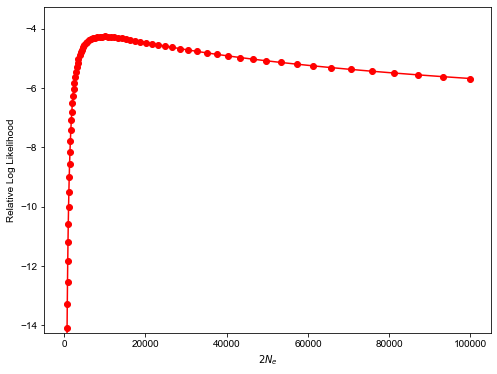

In [162]:
m = np.max(lls)

fs = (8,6)
plt.figure(figsize=fs)
ax = plt.gca()
ax.plot(ns,lls,"ro-")
ax.set_ylim([m-10,m+1])
ax.set_xlabel(f"$2N_e$")
ax.set_ylabel("Relative Log Likelihood")
plt.show()

In [198]:
df_res["0.025"]=2

In [199]:
df_res

,coef,std err,z,P>|z|,0.025,0.975,n,iid
0,NaN,NaN,NaN,NaN,2,NaN,1,I5769.mathieson2018.hs37d5.fa.cons.90perc.trim...
